# lagi lagi Experiment
**Improvements dr baseline:**
- Model: `distilbert-base-cased` (case-sensitive)
- Class weights for imbalance handling
- Threshold optimization
- Early stopping + best checkpoint

In [1]:
!pip install transformers datasets accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 40.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 15.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's de

In [2]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve,
    auc,
    precision_recall_curve
)

from datasets import Dataset
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

2025-12-13 17:35:24.566661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765647324.774215      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765647324.837695      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda
GPU: Tesla T4


# konfigurasi

In [3]:
TRAIN_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/train_rehydrated.jsonl"
TEST_FILE = "/kaggle/input/semeval-2026-psycomark-conspiracy-detection/dev_rehydrated.jsonl"

MODEL_NAME = "distilbert-base-cased"
OUTPUT_DIR = "./distilbert-conspiracy-cased"

LABEL_TO_ID = {"No": 0, "Yes": 1}
ID_TO_LABEL = {0: "No", 1: "Yes"}
NUM_LABELS = 2

MAX_LENGTH = 512
BATCH_SIZE = 16
LEARNING_RATE = 3e-5
EPOCHS = 10
WARMUP_RATIO = 0.1
WEIGHT_DECAY = 0.01
TRAIN_VAL_SPLIT = 0.15

EARLY_STOPPING_PATIENCE = 3

SEED = 42

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)

# preprocess n helper

In [4]:
def preprocess_text(text):
    """Normalize whitespace for consistency."""
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def load_and_filter_data(file_path):
    """Load data and filter out 'Can't tell' labels."""
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                item = json.loads(line)
                if 'conspiracy' in item and item['conspiracy'] in ["Yes", "No"]:
                    item['text'] = preprocess_text(item['text'])
                    data.append(item)
            except json.JSONDecodeError:
                continue
    return data


def load_test_data(file_path):
    """Load test data preserving IDs."""
    data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            try:
                item = json.loads(line)
                sample_id = item.get("_id", f"sample_{i}")
                text = preprocess_text(item.get("text", ""))
                conspiracy = item.get("conspiracy", None)
                data.append({
                    "unique_sample_id": sample_id,
                    "text": text,
                    "conspiracy": conspiracy
                })
            except json.JSONDecodeError:
                continue
    return data

# load n explore data

In [5]:
# Load training data
train_data = load_and_filter_data(TRAIN_FILE)

# Basic statistics
yes_count = sum(1 for d in train_data if d['conspiracy'] == 'Yes')
no_count = sum(1 for d in train_data if d['conspiracy'] == 'No')

print("=" * 50)
print("📊 DATASET STATISTICS")
print("=" * 50)
print(f"Total samples: {len(train_data)}")
print(f"  Yes (Conspiracy):     {yes_count} ({yes_count/len(train_data)*100:.1f}%)")
print(f"  No  (Not Conspiracy): {no_count} ({no_count/len(train_data)*100:.1f}%)")
print(f"  Imbalance ratio:      {max(yes_count, no_count)/min(yes_count, no_count):.2f}:1")

# Text length statistics
text_lengths = [len(d['text'].split()) for d in train_data]
print(f"\nText length (words):")
print(f"  Mean: {np.mean(text_lengths):.1f}")
print(f"  Median: {np.median(text_lengths):.1f}")
print(f"  Min: {min(text_lengths)}, Max: {max(text_lengths)}")

📊 DATASET STATISTICS
Total samples: 3531
  Yes (Conspiracy):     1541 (43.6%)
  No  (Not Conspiracy): 1990 (56.4%)
  Imbalance ratio:      1.29:1

Text length (words):
  Mean: 70.2
  Median: 61.0
  Min: 22, Max: 214


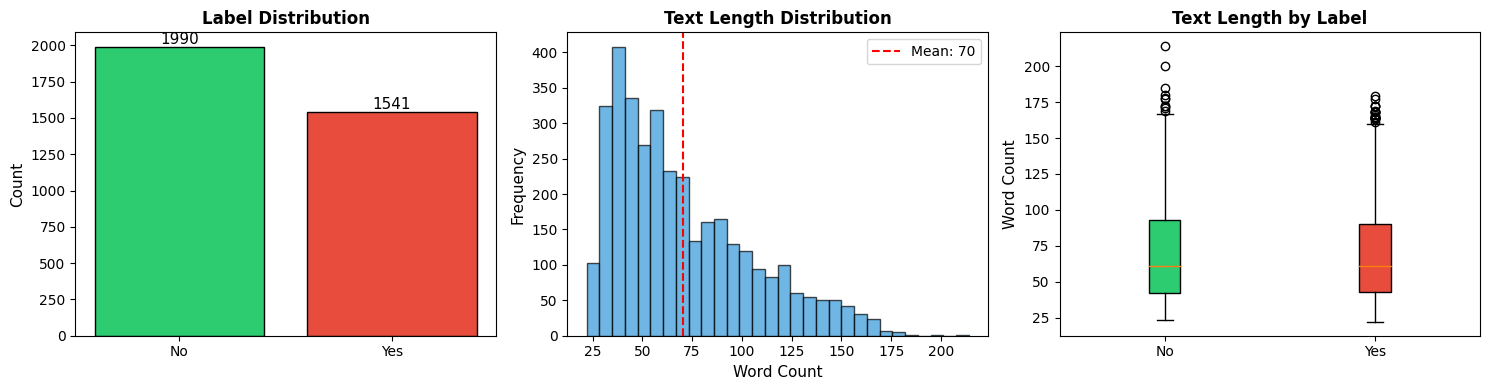

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Label distribution
colors = ['#2ecc71', '#e74c3c']
bars = axes[0].bar(['No', 'Yes'], [no_count, yes_count], color=colors, edgecolor='black')
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Label Distribution', fontsize=12, fontweight='bold')
for bar, count in zip(bars, [no_count, yes_count]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 str(count), ha='center', fontsize=11)

# Plot 2: Text length distribution
axes[1].hist(text_lengths, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(text_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(text_lengths):.0f}')
axes[1].set_xlabel('Word Count', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Text Length Distribution', fontsize=12, fontweight='bold')
axes[1].legend()

# Plot 3: Text length by label
yes_lengths = [len(d['text'].split()) for d in train_data if d['conspiracy'] == 'Yes']
no_lengths = [len(d['text'].split()) for d in train_data if d['conspiracy'] == 'No']
bp = axes[2].boxplot([no_lengths, yes_lengths], labels=['No', 'Yes'], patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][1].set_facecolor('#e74c3c')
axes[2].set_ylabel('Word Count', fontsize=11)
axes[2].set_title('Text Length by Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# train vall split

In [7]:
train_texts = [d['text'] for d in train_data]
train_labels = [d['conspiracy'] for d in train_data]

#stratified split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=TRAIN_VAL_SPLIT,
    random_state=SEED,
    stratify=train_labels
)

print(f"Train set: {len(train_texts)} samples")
print(f"Val set:   {len(val_texts)} samples")

train_yes = sum(1 for l in train_labels if l == 'Yes')
val_yes = sum(1 for l in val_labels if l == 'Yes')
print(f"\nTrain - Yes: {train_yes/len(train_labels)*100:.1f}%")
print(f"Val   - Yes: {val_yes/len(val_labels)*100:.1f}%")

Train set: 3001 samples
Val set:   530 samples

Train - Yes: 43.7%
Val   - Yes: 43.6%


# class weights

In [8]:
train_labels_numeric = [LABEL_TO_ID[l] for l in train_labels]
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels_numeric
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class weights computed:")
print(f"  No (0):  {class_weights[0]:.4f}")
print(f"  Yes (1): {class_weights[1]:.4f}")

#cv ke tensor
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

Class weights computed:
  No (0):  0.8873
  Yes (1): 1.1454


# tokenization\

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels_numeric})
val_dataset = Dataset.from_dict({
    'text': val_texts,
    'labels': [LABEL_TO_ID[l] for l in val_labels]
})

#tokenize function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding=False
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=['text'])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=['text'])

print(f"   Train features: {tokenized_train.features}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

Map:   0%|          | 0/3001 [00:00<?, ? examples/s]

Map:   0%|          | 0/530 [00:00<?, ? examples/s]

   Train features: {'labels': Value('int64'), 'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8'))}


# custom training w weight loss

In [10]:
class WeightedTrainer(Trainer):
    """Custom trainer with class-weighted loss."""
    
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

# metrics function

In [11]:
def compute_metrics(eval_pred):
    """Compute metrics for evaluation."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    return {
        'accuracy': accuracy_score(labels, predictions),
        'f1': f1_score(labels, predictions, average='weighted'),
        'f1_yes': f1_score(labels, predictions, pos_label=1),
        'f1_no': f1_score(labels, predictions, pos_label=0),
        'precision': precision_score(labels, predictions, average='weighted'),
        'recall': recall_score(labels, predictions, average='weighted')
    }

# model n training setup

In [12]:
#load model
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_LABELS,
    id2label=ID_TO_LABEL,
    label2id=LABEL_TO_ID
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#training arguments
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    warmup_ratio=WARMUP_RATIO,
    weight_decay=WEIGHT_DECAY,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=3,
    report_to="none",
    seed=SEED
)

trainer = WeightedTrainer(
    class_weights=class_weights_tensor,
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOPPING_PATIENCE)]
)

print("=" * 50)
print("TRAINING SETUP")
print("=" * 50)
print(f"Model: {MODEL_NAME}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print(f"Warmup ratio: {WARMUP_RATIO}")
print(f"Load best model at end: True")
print(f"Metric for best model: F1")

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING SETUP
Model: distilbert-base-cased
Learning rate: 3e-05
Batch size: 16
Max epochs: 10
Early stopping patience: 3
Warmup ratio: 0.1
Load best model at end: True
Metric for best model: F1


# training

In [13]:
train_result = trainer.train()

print("\n" + "=" * 50)
print("KELAR!!!!")
print("=" * 50)
print(f"Best model loaded from checkpoint")
print(f"Total training time: {train_result.metrics.get('train_runtime', 0):.1f} seconds")

Epoch,Training Loss,Validation Loss,Accuracy,F1,F1 Yes,F1 No,Precision,Recall
1,0.691700,0.600867,0.681132,0.680710,0.630197,0.719735,0.680409,0.681132
2,0.535100,0.625509,0.711321,0.692457,0.578512,0.780488,0.732249,0.711321
3,0.348000,0.588787,0.724528,0.720997,0.658879,0.768987,0.723631,0.724528
4,0.195400,0.695308,0.741509,0.739071,0.685057,0.780800,0.740589,0.741509
5,0.142100,0.873812,0.739623,0.740608,0.716049,0.759582,0.744621,0.739623
6,0.107400,0.964837,0.732075,0.730131,0.677273,0.770968,0.730763,0.732075
7,0.090200,1.132709,0.733962,0.730951,0.672854,0.775835,0.733120,0.733962
8,0.073100,1.156938,0.739623,0.735445,0.672986,0.783699,0.740075,0.739623



KELAR!!!!
Best model loaded from checkpoint
Total training time: 310.2 seconds


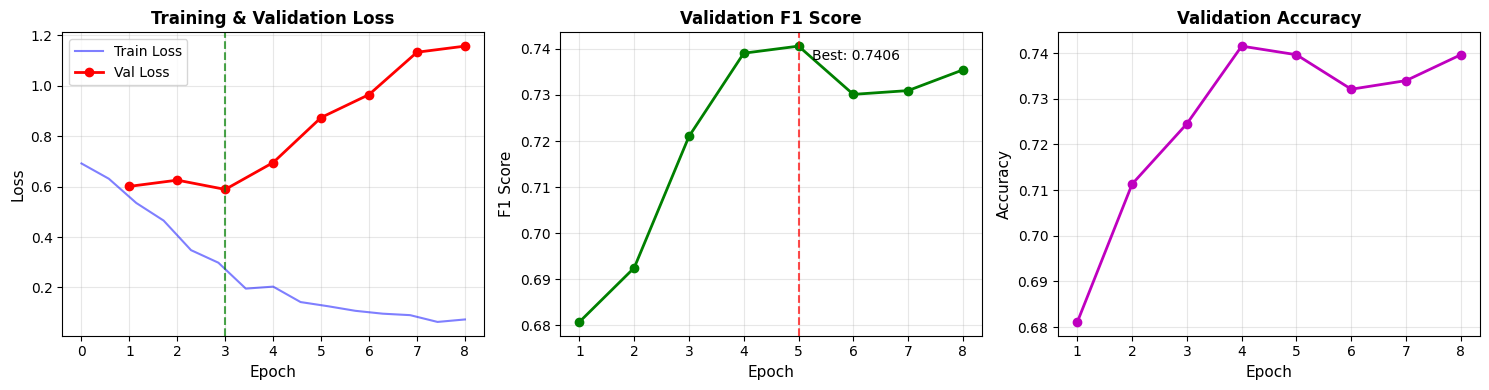


📋 Training Log:
----------------------------------------------------------------------
Epoch   Train Loss     Val Loss       Val F1      Val Acc     
----------------------------------------------------------------------
1       0.6917         0.6009         0.6807      0.6811      
2       0.6311         0.6255         0.6925      0.7113      
3       0.5351         0.5888         0.7210      0.7245      
4       0.4652         0.6953         0.7391      0.7415      
5       0.3480         0.8738         0.7406      0.7396      
6       0.2981         0.9648         0.7301      0.7321      
7       0.1954         1.1327         0.7310      0.7340      
8       0.2033         1.1569         0.7354      0.7396      
----------------------------------------------------------------------
Best epoch: 5 (F1: 0.7406)


In [14]:
# Extract training history
history = trainer.state.log_history

train_losses = []
eval_losses = []
eval_f1s = []
eval_accs = []
epochs_logged = []

for entry in history:
    if 'loss' in entry and 'epoch' in entry:
        train_losses.append(entry['loss'])
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        eval_f1s.append(entry.get('eval_f1', 0))
        eval_accs.append(entry.get('eval_accuracy', 0))
        epochs_logged.append(entry['epoch'])

# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Loss curves
epochs_train = np.linspace(0, len(epochs_logged), len(train_losses))
axes[0].plot(epochs_train, train_losses, 'b-', alpha=0.5, label='Train Loss')
axes[0].plot(epochs_logged, eval_losses, 'r-o', linewidth=2, markersize=6, label='Val Loss')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training & Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Mark best epoch
best_epoch_idx = np.argmin(eval_losses)
axes[0].axvline(epochs_logged[best_epoch_idx], color='green', linestyle='--', alpha=0.7, label=f'Best (epoch {epochs_logged[best_epoch_idx]:.0f})')

# Plot 2: F1 Score
axes[1].plot(epochs_logged, eval_f1s, 'g-o', linewidth=2, markersize=6)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('F1 Score', fontsize=11)
axes[1].set_title('Validation F1 Score', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
best_f1_idx = np.argmax(eval_f1s)
axes[1].axvline(epochs_logged[best_f1_idx], color='red', linestyle='--', alpha=0.7)
axes[1].annotate(f'Best: {eval_f1s[best_f1_idx]:.4f}', 
                 xy=(epochs_logged[best_f1_idx], eval_f1s[best_f1_idx]),
                 xytext=(10, -10), textcoords='offset points', fontsize=10)

# Plot 3: Accuracy
axes[2].plot(epochs_logged, eval_accs, 'm-o', linewidth=2, markersize=6)
axes[2].set_xlabel('Epoch', fontsize=11)
axes[2].set_ylabel('Accuracy', fontsize=11)
axes[2].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# Print training log table
print("\n📋 Training Log:")
print("-" * 70)
print(f"{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}{'Val F1':<12}{'Val Acc':<12}")
print("-" * 70)
for i, epoch in enumerate(epochs_logged):
    tl = train_losses[min(i * (len(train_losses)//len(epochs_logged)), len(train_losses)-1)] if train_losses else 0
    print(f"{epoch:<8.0f}{tl:<15.4f}{eval_losses[i]:<15.4f}{eval_f1s[i]:<12.4f}{eval_accs[i]:<12.4f}")
print("-" * 70)
print(f"Best epoch: {epochs_logged[best_f1_idx]:.0f} (F1: {eval_f1s[best_f1_idx]:.4f})")

# threshold optimization

Optimal Threshold: 0.580
F1 at optimal threshold: 0.7498


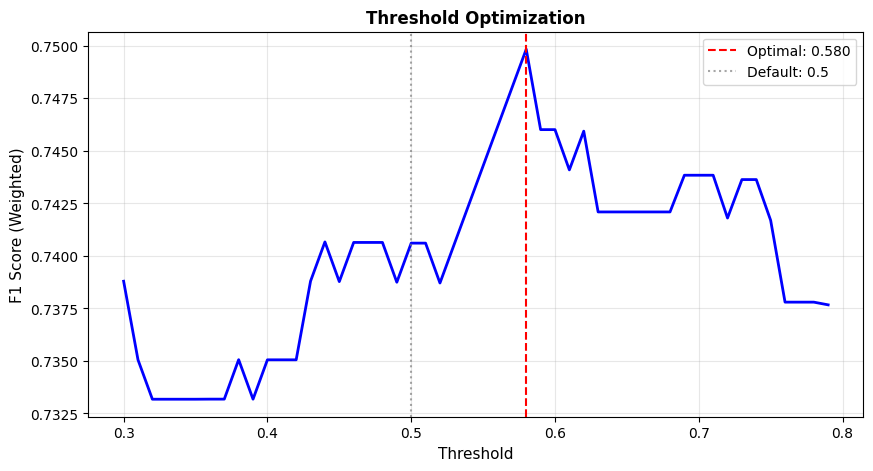

In [15]:
# Get predictions on validation set
val_predictions = trainer.predict(tokenized_val)
val_logits = val_predictions.predictions
val_probs = torch.softmax(torch.tensor(val_logits), dim=-1)[:, 1].numpy()
val_true = np.array([LABEL_TO_ID[l] for l in val_labels])

# Find optimal threshold
thresholds = np.arange(0.3, 0.8, 0.01)
f1_scores = []

for thresh in thresholds:
    preds = (val_probs >= thresh).astype(int)
    f1_scores.append(f1_score(val_true, preds, average='weighted'))

optimal_idx = np.argmax(f1_scores)
OPTIMAL_THRESHOLD = thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"F1 at optimal threshold: {optimal_f1:.4f}")

# Plot threshold vs F1
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, 'b-', linewidth=2)
plt.axvline(OPTIMAL_THRESHOLD, color='red', linestyle='--', label=f'Optimal: {OPTIMAL_THRESHOLD:.3f}')
plt.axvline(0.5, color='gray', linestyle=':', alpha=0.7, label='Default: 0.5')
plt.xlabel('Threshold', fontsize=11)
plt.ylabel('F1 Score (Weighted)', fontsize=11)
plt.title('Threshold Optimization', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('threshold_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# evaluation

In [16]:
val_preds_optimal = (val_probs >= OPTIMAL_THRESHOLD).astype(int)

#calculate metrics
precision = precision_score(val_true, val_preds_optimal, average='weighted')
recall = recall_score(val_true, val_preds_optimal, average='weighted')
f1 = f1_score(val_true, val_preds_optimal, average='weighted')
accuracy = accuracy_score(val_true, val_preds_optimal)

#confusion matrix
cm = confusion_matrix(val_true, val_preds_optimal)
tn, fp, fn, tp = cm.ravel()

print("=" * 60)
print("VALIDATION SET EVALUATION (Optimal Threshold)")
print("=" * 60)
print(f"Threshold: {OPTIMAL_THRESHOLD:.3f}")
print("-" * 60)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print("-" * 60)
print(f"Confusion Matrix:")
print(f"  TN: {tn}  |  FP: {fp}")
print(f"  FN: {fn}  |  TP: {tp}")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(val_true, val_preds_optimal, target_names=['No', 'Yes']))

VALIDATION SET EVALUATION (Optimal Threshold)
Threshold: 0.580
------------------------------------------------------------
Precision: 0.7522
Recall:    0.7491
F1 Score:  0.7498
Accuracy:  0.7491
------------------------------------------------------------
Confusion Matrix:
  TN: 224  |  FP: 75
  FN: 58  |  TP: 173

Classification Report:
              precision    recall  f1-score   support

          No       0.79      0.75      0.77       299
         Yes       0.70      0.75      0.72       231

    accuracy                           0.75       530
   macro avg       0.75      0.75      0.75       530
weighted avg       0.75      0.75      0.75       530



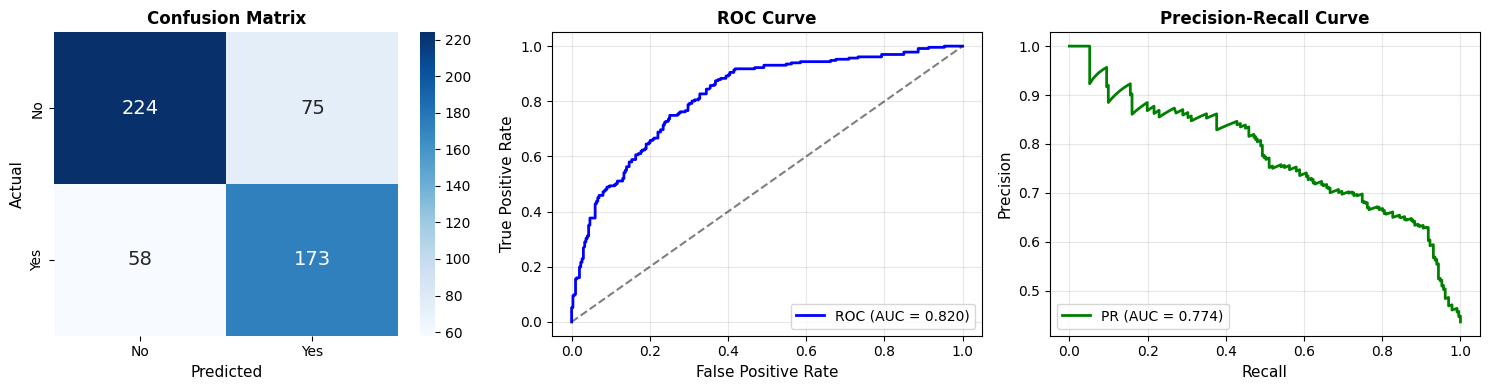

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Confusion Matrix (counts)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'],
            ax=axes[0], annot_kws={'size': 14})
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_title('Confusion Matrix', fontsize=12, fontweight='bold')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

# Plot 3: Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(val_true, val_probs)
pr_auc = auc(recall_curve, precision_curve)
axes[2].plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'PR (AUC = {pr_auc:.3f})')
axes[2].set_xlabel('Recall', fontsize=11)
axes[2].set_ylabel('Precision', fontsize=11)
axes[2].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
axes[2].legend(loc='lower left')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('evaluation_curves.png', dpi=150, bbox_inches='tight')
plt.show()

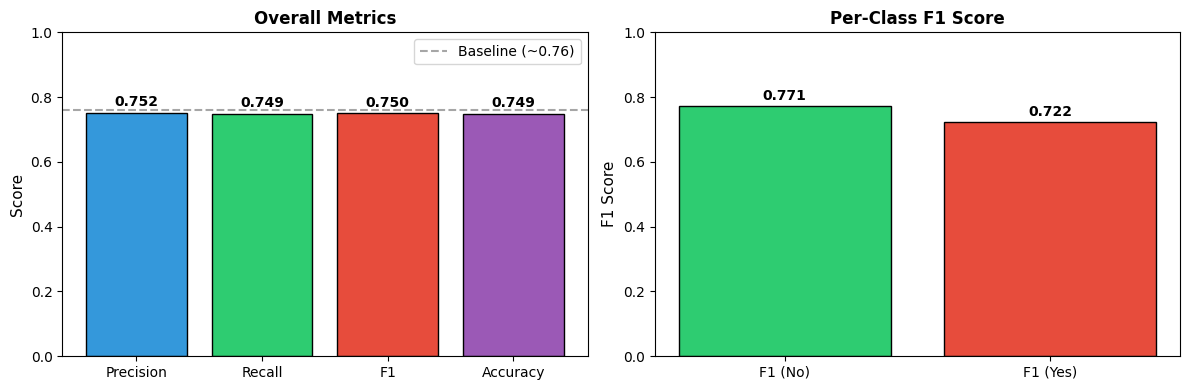

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Overall metrics
metrics_names = ['Precision', 'Recall', 'F1', 'Accuracy']
metrics_values = [precision, recall, f1, accuracy]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6']

bars = axes[0].bar(metrics_names, metrics_values, color=colors, edgecolor='black')
axes[0].set_ylim(0, 1.0)
axes[0].set_ylabel('Score', fontsize=11)
axes[0].set_title('Overall Metrics', fontsize=12, fontweight='bold')
axes[0].axhline(y=0.76, color='gray', linestyle='--', alpha=0.7, label='Baseline (~0.76)')
axes[0].legend()
for bar, val in zip(bars, metrics_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

# Plot 2: Per-class F1
f1_no = f1_score(val_true, val_preds_optimal, pos_label=0)
f1_yes = f1_score(val_true, val_preds_optimal, pos_label=1)
bars2 = axes[1].bar(['F1 (No)', 'F1 (Yes)'], [f1_no, f1_yes], color=['#2ecc71', '#e74c3c'], edgecolor='black')
axes[1].set_ylim(0, 1.0)
axes[1].set_ylabel('F1 Score', fontsize=11)
axes[1].set_title('Per-Class F1 Score', fontsize=12, fontweight='bold')
for bar, val in zip(bars2, [f1_no, f1_yes]):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('metrics_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# error analysis

In [19]:
#pake confident scores
false_positives = []
false_negatives = []
val_preds_labels = [ID_TO_LABEL[p] for p in val_preds_optimal]

for i in range(len(val_labels)):
    true_label = val_labels[i]
    pred_label = val_preds_labels[i]
    confidence = val_probs[i] if pred_label == "Yes" else 1 - val_probs[i]
    
    error_info = {
        'text': val_texts[i],
        'true': true_label,
        'pred': pred_label,
        'confidence': confidence,
        'prob_yes': val_probs[i]
    }
    
    if true_label == "No" and pred_label == "Yes":
        false_positives.append(error_info)
    elif true_label == "Yes" and pred_label == "No":
        false_negatives.append(error_info)

false_positives.sort(key=lambda x: x['confidence'], reverse=True)
false_negatives.sort(key=lambda x: x['confidence'], reverse=True)

print("=" * 70)
print(" ERROR ANALYSIS")
print("=" * 70)

# Summary
total_errors = len(false_positives) + len(false_negatives)
print(f"\nTotal errors: {total_errors} / {len(val_labels)} ({total_errors/len(val_labels)*100:.1f}%)")
print(f"  False Positives (No→Yes): {len(false_positives)} ({len(false_positives)/total_errors*100:.1f}% of errors)")
print(f"  False Negatives (Yes→No): {len(false_negatives)} ({len(false_negatives)/total_errors*100:.1f}% of errors)")

 ERROR ANALYSIS

Total errors: 133 / 530 (25.1%)
  False Positives (No→Yes): 75 (56.4% of errors)
  False Negatives (Yes→No): 58 (43.6% of errors)


# analysis

In [20]:
print("=" * 70)
print(" FALSE POSITIVES: Predicted Yes, Actually No")
print(f"   Total: {len(false_positives)} samples")
print("=" * 70)

if false_positives:
    # Statistics
    fp_lengths = [len(item['text'].split()) for item in false_positives]
    fp_confidences = [item['confidence'] for item in false_positives]
    
    print(f"\n Statistics:")
    print(f"   Avg text length: {np.mean(fp_lengths):.1f} words")
    print(f"   Avg confidence: {np.mean(fp_confidences):.3f}")
    print(f"   High confidence errors (>0.8): {sum(1 for c in fp_confidences if c > 0.8)}")
    
    print(f"\n Top 5 Most Confident False Positives:")
    print("-" * 70)
    for i, item in enumerate(false_positives[:5]):
        print(f"\n[{i+1}] Confidence: {item['confidence']:.3f} (P(Yes)={item['prob_yes']:.3f})")
        print(f"    Text: {item['text'][:250]}...")
        print("-" * 70)

 FALSE POSITIVES: Predicted Yes, Actually No
   Total: 75 samples

 Statistics:
   Avg text length: 72.8 words
   Avg confidence: 0.939
   High confidence errors (>0.8): 68

 Top 5 Most Confident False Positives:
----------------------------------------------------------------------

[1] Confidence: 0.996 (P(Yes)=0.996)
    Text: Caught in another lie, as Trump has claimed he originally knew nothing of the payment Cohen made to Stormy Daniels, yet his financial report claims otherwise. This hits at the credibility of Trumps version of events and strengthens Daniels. This also...
----------------------------------------------------------------------

[2] Confidence: 0.996 (P(Yes)=0.996)
    Text: Statement: Former teen beauty queens have claimed that DT walked in on them whilst they were naked in their changing rooms. The conspiracy being that our POTUS seems to reflect behavior of a potential sexual predator, and is being protected by his ha...
-----------------------------------------

In [21]:
print("=" * 70)
print(" FALSE NEGATIVES: Predicted No, Actually Yes")
print(f"   Total: {len(false_negatives)} samples")
print("=" * 70)

if false_negatives:
    # Statistics
    fn_lengths = [len(item['text'].split()) for item in false_negatives]
    fn_confidences = [item['confidence'] for item in false_negatives]
    
    print(f"\n Statistics:")
    print(f"   Avg text length: {np.mean(fn_lengths):.1f} words")
    print(f"   Avg confidence: {np.mean(fn_confidences):.3f}")
    print(f"   High confidence errors (>0.8): {sum(1 for c in fn_confidences if c > 0.8)}")
    
    print(f"\n Top 5 Most Confident False Negatives:")
    print("-" * 70)
    for i, item in enumerate(false_negatives[:5]):
        print(f"\n[{i+1}] Confidence: {item['confidence']:.3f} (P(Yes)={item['prob_yes']:.3f})")
        print(f"    Text: {item['text'][:250]}...")
        print("-" * 70)

 FALSE NEGATIVES: Predicted No, Actually Yes
   Total: 58 samples

 Statistics:
   Avg text length: 66.0 words
   Avg confidence: 0.878
   High confidence errors (>0.8): 45

 Top 5 Most Confident False Negatives:
----------------------------------------------------------------------

[1] Confidence: 0.997 (P(Yes)=0.003)
    Text: The European Space Agency formally committed to a feasibility study on space solar at their big annual meeting in Paris this week. ESA specifically referenced baseload electricity generation in their reasoning for supporting this idea. Personally, I ...
----------------------------------------------------------------------

[2] Confidence: 0.996 (P(Yes)=0.004)
    Text: store had a good deal and a friend had the arm brace from his old one. So I picked up an FDE one and bought the brace from him. Has light and sig romeo 5. Might bring to work and see how it handles our training....
----------------------------------------------------------------------

[3] Conf

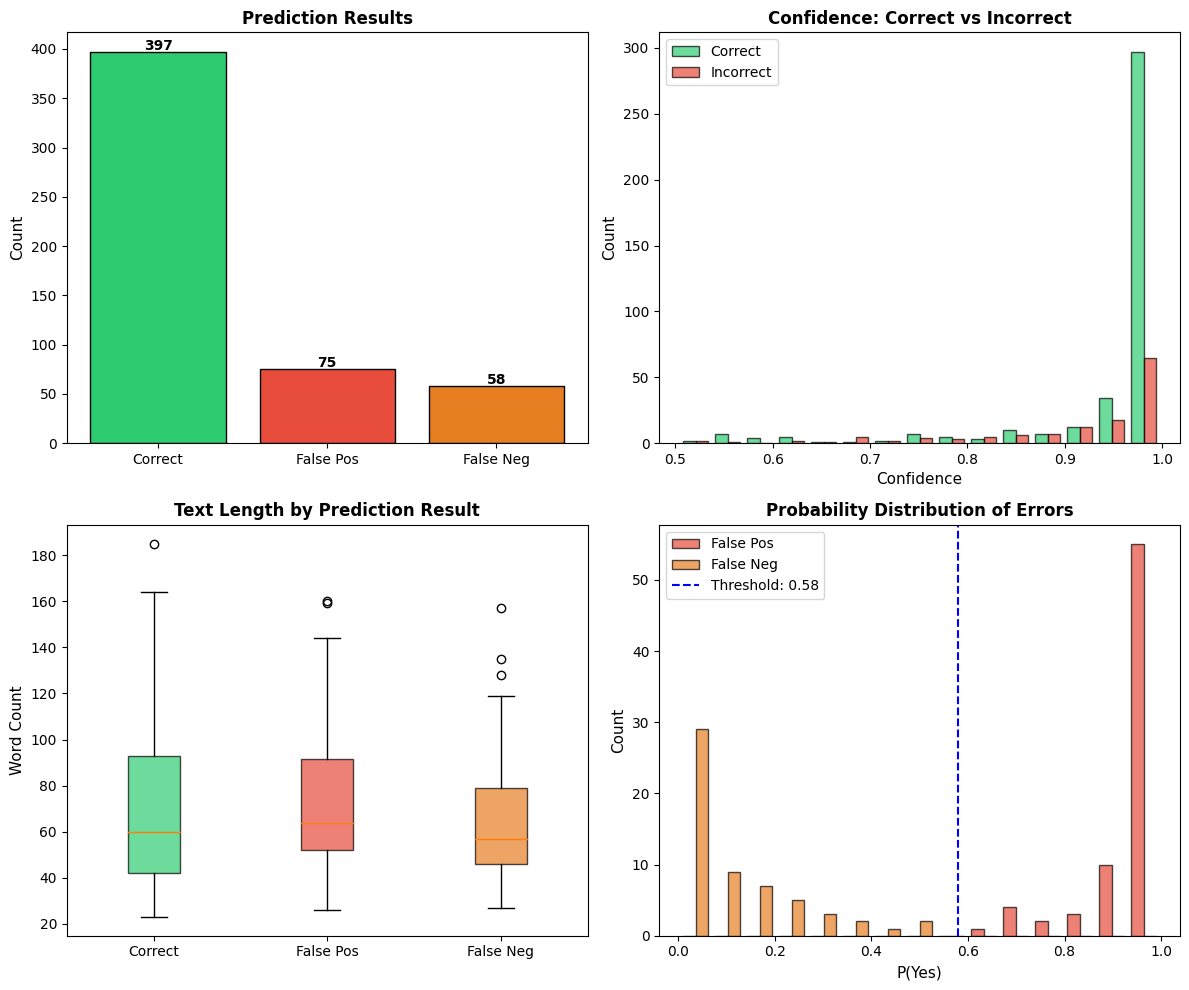

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Error type distribution
correct_count = len(val_labels) - len(false_positives) - len(false_negatives)
error_data = ['Correct', 'False Pos', 'False Neg']
error_counts = [correct_count, len(false_positives), len(false_negatives)]
colors_err = ['#2ecc71', '#e74c3c', '#e67e22']

bars = axes[0, 0].bar(error_data, error_counts, color=colors_err, edgecolor='black')
axes[0, 0].set_ylabel('Count', fontsize=11)
axes[0, 0].set_title('Prediction Results', fontsize=12, fontweight='bold')
for bar, val in zip(bars, error_counts):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                    str(val), ha='center', fontsize=10, fontweight='bold')

# Plot 2: Confidence distribution for correct vs incorrect
correct_mask = np.array([val_labels[i] == val_preds_labels[i] for i in range(len(val_labels))])
correct_conf = np.max(np.column_stack([val_probs, 1-val_probs]), axis=1)[correct_mask]
incorrect_conf = np.max(np.column_stack([val_probs, 1-val_probs]), axis=1)[~correct_mask]

axes[0, 1].hist([correct_conf, incorrect_conf], bins=15, label=['Correct', 'Incorrect'],
                color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Confidence', fontsize=11)
axes[0, 1].set_ylabel('Count', fontsize=11)
axes[0, 1].set_title('Confidence: Correct vs Incorrect', fontsize=12, fontweight='bold')
axes[0, 1].legend()

# Plot 3: Text length vs errors
correct_lengths = [len(val_texts[i].split()) for i in range(len(val_texts)) if correct_mask[i]]
fp_lengths = [len(item['text'].split()) for item in false_positives]
fn_lengths = [len(item['text'].split()) for item in false_negatives]

bp = axes[1, 0].boxplot([correct_lengths, fp_lengths, fn_lengths],
                         labels=['Correct', 'False Pos', 'False Neg'], patch_artist=True)
for patch, color in zip(bp['boxes'], colors_err):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 0].set_ylabel('Word Count', fontsize=11)
axes[1, 0].set_title('Text Length by Prediction Result', fontsize=12, fontweight='bold')

# Plot 4: Probability distribution for FP and FN
if false_positives and false_negatives:
    fp_probs = [item['prob_yes'] for item in false_positives]
    fn_probs = [item['prob_yes'] for item in false_negatives]
    
    axes[1, 1].hist([fp_probs, fn_probs], bins=15, label=['False Pos', 'False Neg'],
                    color=['#e74c3c', '#e67e22'], alpha=0.7, edgecolor='black')
    axes[1, 1].axvline(OPTIMAL_THRESHOLD, color='blue', linestyle='--', label=f'Threshold: {OPTIMAL_THRESHOLD:.2f}')
    axes[1, 1].set_xlabel('P(Yes)', fontsize=11)
    axes[1, 1].set_ylabel('Count', fontsize=11)
    axes[1, 1].set_title('Probability Distribution of Errors', fontsize=12, fontweight='bold')
    axes[1, 1].legend()

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

In [23]:
print("=" * 70)
print("🔍 ERROR PATTERN ANALYSIS")
print("=" * 70)

# Analyze common patterns in errors
def get_word_freq(texts, top_n=10):
    """Get most common words."""
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', text.lower())
        all_words.extend(words)
    # Remove common stopwords
    stopwords = {'the', 'a', 'an', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
                 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
                 'should', 'may', 'might', 'must', 'shall', 'can', 'need', 'dare',
                 'to', 'of', 'in', 'for', 'on', 'with', 'at', 'by', 'from', 'as',
                 'into', 'through', 'during', 'before', 'after', 'above', 'below',
                 'and', 'but', 'or', 'nor', 'so', 'yet', 'both', 'either', 'neither',
                 'not', 'only', 'own', 'same', 'than', 'too', 'very', 'just', 'that',
                 'this', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
                 'what', 'which', 'who', 'whom', 'whose', 'where', 'when', 'why', 'how'}
    filtered = [w for w in all_words if w not in stopwords and len(w) > 2]
    return Counter(filtered).most_common(top_n)

if false_positives:
    print("\n FALSE POSITIVES - Common Words:")
    fp_texts = [item['text'] for item in false_positives]
    for word, count in get_word_freq(fp_texts, 10):
        print(f"   {word}: {count}")

if false_negatives:
    print("\n FALSE NEGATIVES - Common Words:")
    fn_texts = [item['text'] for item in false_negatives]
    for word, count in get_word_freq(fn_texts, 10):
        print(f"   {word}: {count}")

#ringkasan
print("\n" + "=" * 70)
print("KEY INSIGHTS")
print("=" * 70)
print(f"""
1. Total error rate: {total_errors/len(val_labels)*100:.1f}%

2. False Positive rate: {len(false_positives)/sum(1 for l in val_labels if l=='No')*100:.1f}% of actual 'No' samples
   → Model is {'overly sensitive' if len(false_positives) > len(false_negatives) else 'balanced'}

3. False Negative rate: {len(false_negatives)/sum(1 for l in val_labels if l=='Yes')*100:.1f}% of actual 'Yes' samples
   → Model {'misses subtle conspiracies' if len(false_negatives) > 0 else 'catches most conspiracies'}

4. Confidence calibration:
   → Avg confidence on correct: {np.mean(correct_conf):.3f}
   → Avg confidence on errors: {np.mean(incorrect_conf):.3f}
""")

🔍 ERROR PATTERN ANALYSIS

 FALSE POSITIVES - Common Words:
   about: 33
   people: 21
   their: 16
   some: 16
   video: 16
   out: 16
   more: 15
   his: 14
   them: 14
   all: 14

 FALSE NEGATIVES - Common Words:
   all: 20
   his: 17
   one: 16
   their: 14
   people: 14
   most: 13
   000: 12
   american: 12
   made: 12
   about: 11

KEY INSIGHTS

1. Total error rate: 25.1%

2. False Positive rate: 25.1% of actual 'No' samples
   → Model is overly sensitive

3. False Negative rate: 25.1% of actual 'Yes' samples
   → Model misses subtle conspiracies

4. Confidence calibration:
   → Avg confidence on correct: 0.950
   → Avg confidence on errors: 0.913



# INFERENCE

In [24]:
# Load test data
test_data = load_test_data(TEST_FILE)
test_dataset = Dataset.from_dict({
    'unique_sample_id': [d['unique_sample_id'] for d in test_data],
    'text': [d['text'] for d in test_data]
})

unique_ids = test_dataset["unique_sample_id"]
print(f"Test samples: {len(test_data)}")

# Tokenize
tokenized_test = test_dataset.map(tokenize_function, batched=True)
tokenized_test = tokenized_test.remove_columns(["unique_sample_id", "text"])

# Run inference
test_predictions = trainer.predict(tokenized_test)
test_logits = test_predictions.predictions
test_probs = torch.softmax(torch.tensor(test_logits), dim=-1)[:, 1].numpy()

# Apply optimal threshold
test_preds = (test_probs >= OPTIMAL_THRESHOLD).astype(int)
predicted_labels = [ID_TO_LABEL[p] for p in test_preds]

print(f"   Threshold: {OPTIMAL_THRESHOLD:.3f}")
print(f"   Predicted Yes: {sum(test_preds)} ({sum(test_preds)/len(test_preds)*100:.1f}%)")
print(f"   Predicted No: {len(test_preds) - sum(test_preds)} ({(len(test_preds)-sum(test_preds))/len(test_preds)*100:.1f}%)")

Test samples: 100


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

   Threshold: 0.580
   Predicted Yes: 35 (35.0%)
   Predicted No: 65 (65.0%)


# generate submissoin

In [25]:
# Create submission file
SUBMISSION_FILE = "submission.jsonl"

jsonl_lines = []
for i, label in enumerate(predicted_labels):
    jsonl_obj = {"_id": unique_ids[i], "conspiracy": label}
    jsonl_lines.append(json.dumps(jsonl_obj))

with open(SUBMISSION_FILE, 'w') as f:
    f.write('\n'.join(jsonl_lines) + '\n')

print(f"   Total predictions: {len(predicted_labels)}")

# Preview
print("\nPreview:")
for line in jsonl_lines[:3]:
    print(f"   {line}")

   Total predictions: 100

Preview:
   {"_id": "t1_emz6exn", "conspiracy": "Yes"}
   {"_id": "t1_f07ejkp", "conspiracy": "Yes"}
   {"_id": "t1_f6mnlr1", "conspiracy": "Yes"}


In [26]:
import zipfile
import os

ZIP_FILE = "submission.zip"

with zipfile.ZipFile(ZIP_FILE, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(SUBMISSION_FILE)

print(f"   Size: {os.path.getsize(ZIP_FILE):,} bytes")

   Size: 861 bytes


In [27]:
# from IPython.display import FileLink

# print(" Download:")
# display(FileLink('submission.zip'))
# display(FileLink('submission.jsonl'))

 Download:


/kaggle/working/submission.zip

/kaggle/working/submission.jsonl